# LAB EXERCISE 1: SPEAKER IDENTIFICATION

**Authors: Frederik Chettouh and Ainara Apezteguia**

In [1]:
import os

def set_envrionment():
    google_colab = input('Are you using google colab or local jupyter notebook?\nPlease type yes or no.\nYour answer: ')
    if google_colab=='yes':
        from google.colab import drive

# This will prompt for authorization.
        drive.mount('/content/drive')

# Change to assignment directory ('Lab_Exercises_DASS/Lab_Exercise1' by default)
        repository_dir = '/content/drive/My Drive/University/UC3M/bi_semester_4/smart_society'
    
        os.chdir(repository_dir)
    else:
        repository_dir = os.getcwd().replace('/code','')
        
    data_dir = repository_dir + '/' + 'data'
    code_dir = repository_dir + '/' + 'code'
    image_dir = repository_dir + '/' + 'notes' + '/' + 'images'
    
    return repository_dir, data_dir, code_dir, image_dir
repository_dir, data_dir, code_dir, image_dir = set_envrionment()
    

Are you using google colab or local jupyter notebook?
Please type yes or no.
Your answer: no


In [2]:
import numpy  as np
import matplotlib.pyplot as plt
import librosa  # package for speech and audio analysis
from sklearn import mixture
from sklearn.metrics import accuracy_score,confusion_matrix
plt.style.use('default')
from IPython.display import Image
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

seed = 0

In [3]:
nomlist_train = 'Train_List.txt';
nomlist_test = ['Test_List1.txt', 'Test_List2.txt']
print("Training list: " + nomlist_train)
print("Test list 1 (clean conditions): "+ nomlist_test[0])
print("Test list 2 (noisy conditions): "+ nomlist_test[1])

Training list: Train_List.txt
Test list 1 (clean conditions): Test_List1.txt
Test list 2 (noisy conditions): Test_List2.txt


### Sampling Rate
The sampling rate --- typically fs in the digital signal processing literature, or sr in librosa --- is defined as 1/ts, where ts is the amount of time (in seconds) between successive samples. Equivalently, fs is the number of observations per second in the discretely sampled signal

Source: https://librosa.github.io/

speechdata/irm01/irm01_s01_test1.wav
Number of samples in file speechdata/irm01/irm01_s01_test1.wav = 41386
Sampling frequency = 16000 Hz


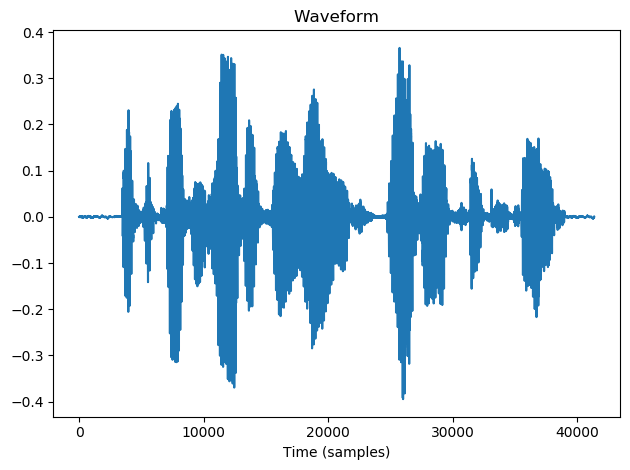

In [4]:
# Reading a speech file from the database
# --------------------------------------------------------------------
sample = 'speechdata/irm01/irm01_s01_test1.wav'
speech_name = data_dir + '/' + sample
print(sample)

# x: speech signal : time series as numpy array

# fs: sampling frequency
x, fs = librosa.load(speech_name, sr=None)
print("Number of samples in file " +sample+" = "+str(x.shape[0]))
print("Sampling frequency = "+str(fs)+" Hz")

fig, ax = plt.subplots()
plt.plot(x)
plt.title('Waveform')
ax.set_xlabel('Time (samples)')
plt.tight_layout()
plt.show()
plt.close()

In the following, we show an example of feature extraction for the previous speech signal *x*.

In particular, we want to compute a set of mel-frequency cepstrum coefficients (MFCC) with the following configuration:

* Size of the analysis window = 20 ms

* Frame period or hop length = 10 ms

* Number of filters in the mel filterbank = 40

* Number of MFCC components = 20

For doing that, we are going to use the function **mfcc** from the module *feature* of the *librosa* package. This function has, among others, the following input arguments:

* y: speech signal 
* sr: sampling frequency
* n_fft: window size (in samples)
* hop_length: frame period or hop length (in samples)
* n_mels: number of filters in the mel filterbank
* n_mfcc: number of MFCC components

Note that in this function the window size and the hop length must be expressed in samples. Taking into account that the sampling frequency (fs) indicates that 1 second correspond to fs samples (in our case, as fs=16 kHz, 1 second corresponds to 16000 samples), the conversion from **seconds** to **samples** is performed by:

```
samples = seconds*fs = seconds*16000
```

With the previous information, fill the values of the configuration variables in the next code.



In [5]:
def calc_window_size(fs,window_size_in_ms=20):
    return int(fs/1000*window_size_in_ms)
def calc_hop_length(fs, hop_lenght_in_ms=10):
    return int(fs/1000*hop_lenght_in_ms)

In [6]:
# --------------------------------------------------------------------
# Configuration variables for feature extraction
# --------------------------------------------------------------------

##################################
# - FILL THE VALUES OF THE FOLLOWING CONFIGURATION VARIABLES
##################################

wst = 1/1000*20       # Window size (seconds)
fpt = 1/1000*10       # Frame period (seconds) 
nfft = calc_window_size(fs)      # Window size (samples)
fp = calc_hop_length(fs)        # Frame period (samples)
nbands = 40    # 
ncomp = 20     # Number of MFCC components

The dimensions of the resulting MFCC must be,

```
(ncomp x T)
```

being *T* the number of frames of the speech signal, which is computed as the number of samples of the speech signal divided by the hop length (in samples), rounded off to the ceil integer.

The following code computes the MFCC features considering the previously configured variables.

Check the dimensions of the resulting MFCC features.


In [7]:
# --------------------------------------------------------------------
# Example of MFCC computation
# --------------------------------------------------------------------

# Feature extraction (MFCC computation)
mfcc = librosa.feature.mfcc(y=x,
                            sr=fs,
                            n_fft=nfft,
                            hop_length=fp,
                            n_mels=nbands,
                            n_mfcc=ncomp)

seconds_of_snippet = librosa.core.get_duration(x,sr=fs)
T = seconds_of_snippet/fpt
print('The audio file is of lenght {} seconds.\nGiven the sampling rate of {}\and a hop length of {} we should see {} dimensions'.format(
        round(seconds_of_snippet,2),fs, fpt, round(T))
)
print('The dimensions of the mfcc object are {} by {}'.format(mfcc.shape[0], 
                                                              mfcc.shape[1]))

The audio file is of lenght 2.59 seconds.
Given the sampling rate of 16000nd a hop length of 0.01 we should see 259 dimensions
The dimensions of the mfcc object are 20 by 259


## Theoretical understanding of Gaussian Mixture Models

__Gaussian Mixture Models -  Under the hood__:
Given a number of components Gaussian Mixtures attempt to maximize the the liklihood, that the data belongs to a normal distribution. 

Therefore it is not so much a clustering but an estimator of the overall density.

__Hyperparameters:__
- covariance_type: The covariance type for each component.
The covariance controls the spread of the data, i.e. in one or in the multivariate case in n directions. It thus determines the possible size of a component. Moreover, the type of covariance constrains the shape of the cluster. I.e. diagonal means that the cluster and only expand along the axis since the covariance entries are zero. Speherical constrains the covariance matrix to a spehre.

- n_components:
The components is number of Gaussian distributions that we believe the data was generated from.
In the Moon example although there are clearly two clusters, a good choice seems to be 16 components. Some components have a very narrow kernel while others are wide. $$N~(x;\mu,\sigma^2) = \frac{1}{\sqrt{2\pi * \sigma^2}}*exp((\frac{(x-\mu)^2}{2\sigma}))$$ This means that some of these components have a large and other a small standard deviation.

In the third picture the author drew 25 from the 16 multivariate Gaussian thus getting 400 points which model the data very well.

So in our case we use 8 components but we are building 16 different models. This is akin to saying that the voice snippet can be modelled with 8 components. Thus at test times we maximize the Liklihood with all 16 models and pick the label of the one that maximizes the likelihood.

In [8]:
imgs = ['16comp_moondatacluster.png','16comp_moondata.png','16comp_sampling.png']
for img in (imgs):
    file = Image(image_dir + '/' + img)
    display(file)
    

FileNotFoundError: No such file or directory: '/Users/admin/Documents/BIMESTRE_4_MASTER/analytics_for_smart_society/notes/images/16comp_moondatacluster.png'

FileNotFoundError: No such file or directory: '/Users/admin/Documents/BIMESTRE_4_MASTER/analytics_for_smart_society/notes/images/16comp_moondatacluster.png'

<IPython.core.display.Image object>

FileNotFoundError: No such file or directory: '/Users/admin/Documents/BIMESTRE_4_MASTER/analytics_for_smart_society/notes/images/16comp_moondata.png'

FileNotFoundError: No such file or directory: '/Users/admin/Documents/BIMESTRE_4_MASTER/analytics_for_smart_society/notes/images/16comp_moondata.png'

<IPython.core.display.Image object>

FileNotFoundError: No such file or directory: '/Users/admin/Documents/BIMESTRE_4_MASTER/analytics_for_smart_society/notes/images/16comp_sampling.png'

FileNotFoundError: No such file or directory: '/Users/admin/Documents/BIMESTRE_4_MASTER/analytics_for_smart_society/notes/images/16comp_sampling.png'

<IPython.core.display.Image object>

## Training the Gaussian Mixture Models

In [9]:
ngauss = 8

In [10]:
def load_n_preprocess(filename,directory=data_dir):
    with open (directory + '/' + filename) as f:
        content = f.readlines()
    nspk = len(content)

    data = np.array([line.strip().split(' ') for line in content])
    files_speech_train = data[:,0]
    labels_train = data[:,1].astype(np.int16)
    return nspk, files_speech_train, labels_train

In [11]:
nspk, files_speech_train,labels_train = load_n_preprocess('Train_List.txt')

In [12]:
def extract_data(data_dir,
                 labels,
                 files_speech,
                 sr=None):
    return [{
        'label': label,
        'raw_data':librosa.load(data_dir + '/' + file, sr=sr)[0],
        'sr':librosa.load(data_dir + '/' + file, sr=sr)[1]}
        for label, file in zip(labels,files_speech)]

In [13]:
def extract_features(data_dict,
                     window_size=wst,
                     frame_period=fpt,
                     nbands=nbands,
                     ncomp=ncomp):
    for dic in data_dict:
        x = dic['raw_data']
        fs = dic['sr']
        nfft = calc_window_size(fs)    
        fp = calc_hop_length(fs)
        mfcc = librosa.feature.mfcc(y=x,
                            sr=fs,
                            n_fft=nfft,
                            hop_length=fp,
                            n_mels=nbands,
                            n_mfcc=ncomp)
        dic['mfcc_features'] = mfcc
    
    return data_dict
        

In [14]:
def train_models(params,
                 data_dir=data_dir,
                 labels=labels_train,
                 files_speech=files_speech_train,
                 sr=None):
    all_data = extract_data(data_dir,
                            labels,
                            files_speech,
                            sr)
    
    all_data = extract_features(all_data)
    index = 0
    for dic in all_data:
        dic['model'] = (mixture.GaussianMixture(**params))
        try:
            dic['model'].fit(np.transpose(dic['mfcc_features']))
        except ValueError:
            print('Change "reg_covar for model {}"'.format(index))
        finally:
            index += 1
    return all_data

In [15]:
trained_models = train_models(params={
    'n_components':ngauss,
    'covariance_type':'diag',
    'n_init':1,
    'random_state':seed,
    'reg_covar':1e-2
})

## Testing the Gaussian Mixture Models

####  Clean conditions

In [16]:
nspk_test, files_speech_test,labels_test = load_n_preprocess('Test_List1.txt')

In [17]:
def calc_accuracy(test_data):
    denom = len(test_data)
    nominator =  sum([entry['label']==entry['predicted_label']for entry in test_data])
    return round(100*nominator/denom,2)

In [18]:
def test_models(trained_models,
                data_dir,
                labels_test,
                files_speech_test,
                sr=None):
    test_data = extract_data(data_dir,
                             labels_test,
                             files_speech_test,
                             sr)
    
    test_data = extract_features(test_data)
    for snippit in test_data:
        snippit['likelihoods'] = np.array(
            [entry['model'].score(np.transpose(snippit['mfcc_features'])) for entry in trained_models])
        snippit['predicted_label'] = np.argmax(snippit['likelihoods'])
    accuracy = calc_accuracy(test_data)
    return test_data,accuracy

In [19]:
tested_models,accuracy_cleandata = test_models(trained_models,
                                                data_dir,
                                                labels_test,
                                                files_speech_test)

In [20]:
print('The test accuracy on the clean test data is: {}'.format(accuracy_cleandata))

The test accuracy on the clean test data is: 98.75


#### Noisy conditions

In [21]:
nspk_test_noise, files_speech_test_noise,labels_test_noise = load_n_preprocess('Test_List2.txt')

In [22]:
tested_models_noise,accuracy_noisedata = test_models(trained_models,
                                                data_dir,
                                                labels_test_noise,
                                                files_speech_test_noise)

In [23]:
print('The test accuracy on the clean test data is: {}'.format(accuracy_noisedata))

The test accuracy on the clean test data is: 45.62


# Improvements on the baseline system

The following approaches will be carried out individually:

- Filtering
- Hyperparameter tuning
- Feature engineering

Finally, the parameters/features which gave the best performance in each section are going to be combined with the ones in the rest of the sections. 

### Filtering

See if the accuracy of noisy test set can be improved by applying filters:

#### Median filter

In [24]:
def reduce_noise_median(y, sr=None):
    y = sp.signal.medfilt(y,sr)
    return (y)

In [25]:
def extract_features_median(data_dict,
                     window_size=wst,
                     frame_period=fpt,
                     nbands=nbands,
                     ncomp=ncomp):
    for dic in data_dict:
        x = dic['filt_data']
        fs = dic['sr']
        nfft = calc_window_size(fs)    
        fp = calc_hop_length(fs)
        mfcc = librosa.feature.mfcc(y=x,
                            sr=fs,
                            n_fft=nfft,
                            hop_length=fp,
                            n_mels=nbands,
                            n_mfcc=ncomp)
        dic['mfcc_features'] = mfcc
    
    return data_dict

In [26]:
def test_median(trained_models,
                data_dir,
                labels_test,
                files_speech_test,
                sr=None):

    test_data = extract_data(data_dir,
                             labels_test,
                             files_speech_test,
                             sr)
 
    for snippit in test_data:
        snippit['filt_data']=reduce_noise_median(snippit['raw_data'],sr=None)

    test_data = extract_features_median(test_data)
    for snippit in test_data:
        snippit['likelihoods'] = np.array(
            [entry['model'].score(np.transpose(snippit['mfcc_features'])) for entry in trained_models])
        snippit['predicted_label'] = np.argmax(snippit['likelihoods'])
    accuracy = calc_accuracy(test_data)
    return test_data,accuracy

In [27]:
tested_models,accuracy_median = test_median(trained_models,
                                                data_dir,
                                                labels_test_noise,
                                                files_speech_test_noise)

In [28]:
print('The test accuracy on the noisy test data is: {}'.format(accuracy_median))

The test accuracy on the noisy test data is: 45.62


The median filter does not improve the performance, we will visualize the effect on one audio from the noisy test dataset and we will compare it to the clean and noisy data. We will also consider wiener filter: 

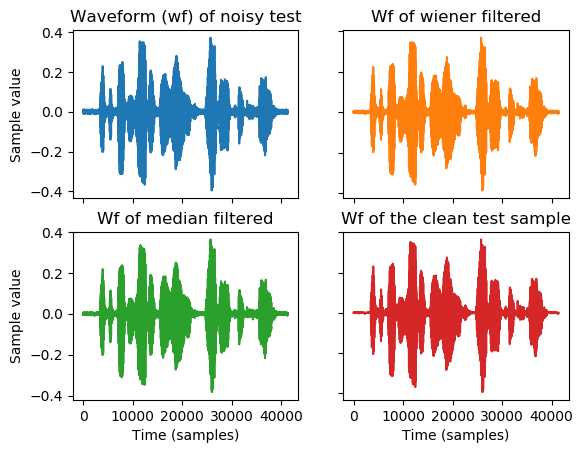

In [29]:
x, fs = librosa.load(data_dir + '/' +files_speech_test_noise[0], sr=None)
x3, fs3 = librosa.load(data_dir + '/' +files_speech_test[0], sr=None)

filtered_x=sp.signal.wiener(x)
filtered_x2=reduce_noise_median(x)
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x)
axs[0, 0].set_title('Waveform (wf) of noisy test')
axs[0, 1].plot(filtered_x, 'tab:orange')
axs[0, 1].set_title('Wf of wiener filtered')
axs[1, 0].plot(filtered_x2, 'tab:green')
axs[1, 0].set_title('Wf of median filtered')
axs[1, 1].plot(x3, 'tab:red')
axs[1, 1].set_title('Wf of the clean test sample')

for ax in axs.flat:
    ax.set(xlabel='Time (samples)', ylabel='Sample value')

for ax in axs.flat:
    ax.label_outer()

The graph corresponding to the median filter is very close to the original noisy audio, it is reasonable to get the exact same accuracy than for the noisy test data. It looks like the wiener filter will not improve the performance either. New filters are applied below:


#### Power filter

In [29]:
from pysndfx import AudioEffectsChain
def reduce_noise_power(y, sr):

    cent = librosa.feature.spectral_centroid(y, sr)

    threshold_h = round(np.median(cent))*1.5
    threshold_l = round(np.median(cent))*0.1

    less_noise = AudioEffectsChain().lowshelf(gain=-30.0, frequency=threshold_l, slope=0.8).highshelf(gain=-12.0, frequency=threshold_h, slope=0.5)#.limiter(gain=6.0)
    y_clean = less_noise(y)

    return y_clean

In [41]:
def test_rnp(trained_models,
                data_dir,
                labels_test,
                files_speech_test,
                sr=fs):

    test_data = extract_data(data_dir,
                             labels_test,
                             files_speech_test,
                             sr)
 
    for snippit in test_data:
        snippit['filt_data']=reduce_noise_power(snippit['raw_data'],sr)

    test_data = extract_features_median(test_data)
    for snippit in test_data:
        snippit['likelihoods'] = np.array(
            [entry['model'].score(np.transpose(snippit['mfcc_features'])) for entry in trained_models])
        snippit['predicted_label'] = np.argmax(snippit['likelihoods'])
    accuracy = calc_accuracy(test_data)
    return test_data,accuracy

In [42]:
tested_models,accuracy_rnp = test_rnp(trained_models,
                                                data_dir,
                                                labels_test_noise,
                                                files_speech_test_noise)

In [43]:
print('The test accuracy on the noisy test data is: {}'.format(accuracy_rnp))

The test accuracy on the noisy test data is: 63.12


It does a better job than the median filter, but another filter is going to be applied to see if the accuracy improves:

#### Centroid filter

In [37]:
def reduce_noise_centroid_s(y, sr):

    cent = librosa.feature.spectral_centroid(y=y, sr=sr)

    threshold_h = np.max(cent)
    threshold_l = np.min(cent)

    less_noise = AudioEffectsChain().lowshelf(gain=-12.0, frequency=threshold_l, slope=0.5).highshelf(gain=-12.0, frequency=threshold_h, slope=0.5).limiter(gain=6.0)

    y_cleaned = less_noise(y)

    return y_cleaned

In [38]:
def test_rnc(trained_models,
                data_dir,
                labels_test,
                files_speech_test,
                sr=fs):

    test_data = extract_data(data_dir,
                             labels_test,
                             files_speech_test,
                             sr)
 
    for snippit in test_data:
        snippit['filt_data']=reduce_noise_centroid_s(snippit['raw_data'],sr)
        

    test_data = extract_features_median(test_data)
    for snippit in test_data:
        snippit['likelihoods'] = np.array(
            [entry['model'].score(np.transpose(snippit['mfcc_features'])) for entry in trained_models])
        snippit['predicted_label'] = np.argmax(snippit['likelihoods'])
    accuracy = calc_accuracy(test_data)
    return test_data,accuracy

In [39]:
tested_models,accuracy_rnc = test_rnc(trained_models,
                                                data_dir,
                                                labels_test_noise,
                                                files_speech_test_noise)

In [40]:
print('The test accuracy on the noisy test data is: {}'.format(accuracy_rnc))

The test accuracy on the noisy test data is: 66.88


The performance has been improved. Now both filters are going to be applied at the same time to see if the performance improves even more:

####  Power filter + Centroid filter

In [44]:
def test_both1(trained_models,
                data_dir,
                labels_test,
                files_speech_test,
                sr=fs):

    test_data = extract_data(data_dir,
                             labels_test,
                             files_speech_test,
                             sr)
 
    for snippit in test_data:
        snippit['filt_data']=reduce_noise_power(snippit['raw_data'],sr)
        snippit['filt_data']=reduce_noise_centroid_s(snippit['filt_data'],sr)
        

    test_data = extract_features_median(test_data)
    for snippit in test_data:
        snippit['likelihoods'] = np.array(
            [entry['model'].score(np.transpose(snippit['mfcc_features'])) for entry in trained_models])
        snippit['predicted_label'] = np.argmax(snippit['likelihoods'])
    accuracy = calc_accuracy(test_data)
    return test_data,accuracy

In [45]:
tested_models,accuracy_both = test_both1(trained_models,
                                                data_dir,
                                                labels_test_noise,
                                                files_speech_test_noise)

In [46]:
print('The test accuracy on the noisy test data is: {}'.format(accuracy_both))

The test accuracy on the noisy test data is: 48.12


Maybe if the centroid filter is applied before the noise power filter a better accuracy is obtained:

#### Centroid filter + Power filter

In [47]:
def test_both(trained_models,
                data_dir,
                labels_test,
                files_speech_test,
                sr=fs):

    test_data = extract_data(data_dir,
                             labels_test,
                             files_speech_test,
                             sr)
 
    for snippit in test_data:
        snippit['filt_data']=reduce_noise_centroid_s(snippit['raw_data'],sr)
        snippit['filt_data']=reduce_noise_power(snippit['filt_data'],sr)

    test_data = extract_features_median(test_data)
    for snippit in test_data:
        snippit['likelihoods'] = np.array(
            [entry['model'].score(np.transpose(snippit['mfcc_features'])) for entry in trained_models])
        snippit['predicted_label'] = np.argmax(snippit['likelihoods'])
    accuracy = calc_accuracy(test_data)
    return test_data,accuracy

In [48]:
tested_models,accuracy_both = test_both(trained_models,
                                                data_dir,
                                                labels_test_noise,
                                                files_speech_test_noise)

In [49]:
print('The test accuracy on the noisy test data is: {}'.format(accuracy_both))

The test accuracy on the noisy test data is: 63.12


The accuracy in this order of filter application is better but it is still worse than using **only the centroid filter**.

### Hyperparameter tuning

- Number of gaussian models
- GMM covariances

### Number of gaussian components

#### Number of gaussian models for the clean data

In [44]:
for ngauss in [5,8,9,10,20,21,25]:


    trained_models = train_models(params={
        'n_components':ngauss,
        'covariance_type':'diag',
        'n_init':1,
        'random_state':seed,
        'reg_covar':1e-2
    })
    nspk_test, files_speech_test,labels_test = load_n_preprocess('Test_List1.txt')
    tested_models,accuracy_cleandata = test_models(trained_models,
                                                data_dir,
                                                labels_test,
                                                files_speech_test)
    print('The test accuracy on the clean test data with ' +str(ngauss)+' mixture components'+' is: '+str(accuracy_cleandata))
    

The test accuracy on the clean test data with 5 mixture components is: 98.12
The test accuracy on the clean test data with 8 mixture components is: 98.75
The test accuracy on the clean test data with 9 mixture components is: 97.5
The test accuracy on the clean test data with 10 mixture components is: 96.25
The test accuracy on the clean test data with 20 mixture components is: 98.75
The test accuracy on the clean test data with 21 mixture components is: 98.12
The test accuracy on the clean test data with 25 mixture components is: 99.38


#### Number of gaussian models for the noisy data

In [50]:
for ngauss in [5,8,9,10,20,21,25]:


    trained_models = train_models(params={
        'n_components':ngauss,
        'covariance_type':'diag',
        'n_init':1,
        'random_state':seed,
        'reg_covar':1e-2
    })
    nspk_test_noise, files_speech_test_noise,labels_test_noise = load_n_preprocess('Test_List2.txt')
    tested_models_noise,accuracy_noisedata = test_models(trained_models,
                                                data_dir,
                                                labels_test_noise,
                                                files_speech_test_noise)
    print('The test accuracy on the noisy test data with ' +str(ngauss)+' mixture components'+' is: '+str(accuracy_noisedata))

The test accuracy on the noisy test data with 5 mixture components is: 42.5
The test accuracy on the noisy test data with 8 mixture components is: 45.62
The test accuracy on the noisy test data with 9 mixture components is: 46.25
The test accuracy on the noisy test data with 10 mixture components is: 51.25
The test accuracy on the noisy test data with 20 mixture components is: 45.0
The test accuracy on the noisy test data with 21 mixture components is: 50.0
The test accuracy on the noisy test data with 25 mixture components is: 49.38


We are interested in improving the performance of the noisy test data, as it is the most realistic one, and it turns out that using 10 gaussian models its performance is improved, we set ngauss to 10 for this section of hyperparameter tuning.

In [51]:
ngauss = 10

### Covariance

#### Covariance in the clean data

In [52]:
for cov in ['diag','full','tied','spherical']:


    trained_models = train_models(params={
        'n_components':ngauss,
        'covariance_type':cov,
        'n_init':1,
        'random_state':seed,
        'reg_covar':1e-2
    })
    nspk_test, files_speech_test,labels_test = load_n_preprocess('Test_List1.txt')
    tested_models,accuracy_cleandata = test_models(trained_models,
                                                data_dir,
                                                labels_test,
                                                files_speech_test)
    print('The test accuracy on the clean test data with ' +str(cov)+' covariance'+' is: '+str(accuracy_cleandata))

The test accuracy on the clean test data with diag covariance is: 96.25
The test accuracy on the clean test data with full covariance is: 88.12
The test accuracy on the clean test data with tied covariance is: 100.0
The test accuracy on the clean test data with spherical covariance is: 74.38


#### Covariance in the noisy data

In [53]:
for cov in ['diag','full','tied','spherical']:


    trained_models = train_models(params={
        'n_components':ngauss,
        'covariance_type':cov,
        'n_init':1,
        'random_state':seed,
        'reg_covar':1e-2
    })
    nspk_test_noise, files_speech_test_noise,labels_test_noise = load_n_preprocess('Test_List2.txt')
    tested_models_noise,accuracy_noisedata = test_models(trained_models,
                                                data_dir,
                                                labels_test_noise,
                                                files_speech_test_noise)
    print('The test accuracy on the noisy test data with ' +str(cov)+' covariance'+' is: '+str(accuracy_noisedata))

The test accuracy on the noisy test data with diag covariance is: 51.25
The test accuracy on the noisy test data with full covariance is: 65.62
The test accuracy on the noisy test data with tied covariance is: 49.38
The test accuracy on the noisy test data with spherical covariance is: 20.0


So from this section we conlude that **10 gaussian mixtures and a full covariance matrix** gives us the best accuracy for the noisy test dataset.

## Feature engineering

In [54]:
ngauss=8

The first step in any automatic speech recognition system is to extract features. This way, only the components of the audio signal that are good for identifying linguistic content are retrieved. Sounds generated by a human are filtered by the shape of the vocal tract and this shape is determinant in the sound that comes out. So, determining the shape accurately enables us to represent the phoneme produced. The shape of the vocal tract manifests itself in the the short time power spectrum range, MFCCs accurately represent this range by relating the perceived frequency of a pure tone to its actual measured frequency. A scale is implemented to make the features more close to what humans hear (discern small changes in pitch better at low freuqencies than high).

Moreover, the MFCC feature vector only describes the power spectral envelope of a single frame resulting in a loss of information as dynamics is not taken ino account (the trajectories of the MFCC over time). It turns out that calculating the MFCC trajectories and appending them to the original feature vector increases ASR performance by quite a bit. This can be done wit the delta coefficients:




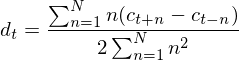

In [15]:
#img='Delta_formula.png'
#file = Image(code_dir + '/' + img)

file = Image('/Users/admin/Documents/BIMESTRE_4_MASTER copia/analytics_for_smart_society/code/Delta_formula.png')
display(file)

where $d_{t}$ is a delta coefficient, from frame $t$ computed in terms of the static coefficients $c_{t+N}$ to $c_{t-N}$. A typical value for N is 2. 

Now we are going to add these features to the already used mfcc features:

In [55]:
def extract_dataD(data_dir,
                 labels,
                 files_speech,
                 sr=None):
    return [{
        'label': label,
        'raw_data':librosa.load(data_dir + '/' + file, sr=sr)[0],
        'sr':librosa.load(data_dir + '/' + file, sr=sr)[1]}
        for label, file in zip(labels,files_speech)]

In [56]:
def extract_featuresD(data_dict,
                     window_size=wst,
                     frame_period=fpt,
                     nbands=nbands,
                     ncomp=ncomp):
    for dic in data_dict:
        x = dic['raw_data']
        fs = dic['sr']
        nfft = calc_window_size(fs)    
        fp = calc_hop_length(fs)
        mfcc = librosa.feature.mfcc(y=x,
                            sr=fs,
                            n_fft=nfft,
                            hop_length=fp,
                            n_mels=nbands,
                            n_mfcc=ncomp)
        dic['mfcc_features'] = mfcc.T
        dic['delta'] =librosa.feature.delta(dic['mfcc_features'])
        dic['combined'] = np.hstack((dic['mfcc_features'],dic['delta']))
  


    
    return data_dict

In [57]:
def train_modelsD(params,
                 data_dir=data_dir,
                 labels=labels_train,
                 files_speech=files_speech_train,
                 sr=None):
    all_data = extract_dataD(data_dir,
                            labels,
                            files_speech,
                            sr)
    
    all_data = extract_featuresD(all_data)
    index = 0
    for dic in all_data:
        dic['model'] = (mixture.GaussianMixture(**params))
        try:
            dic['model'].fit(dic['combined'])
        except ValueError:
            print('Change "reg_covar for model {}"'.format(index))
        finally:
            index += 1
    return all_data

In [58]:
trained_modelsD = train_modelsD(params={
    'n_components':ngauss,
    'covariance_type':'diag',
    'n_init':1,
    'random_state':seed,
    'reg_covar':1e-2
})

In [59]:
def test_modelsD(trained_models,
                data_dir,
                labels_test,
                files_speech_test,
                sr=None):
    test_data = extract_dataD(data_dir,
                             labels_test,
                             files_speech_test,
                             sr)
    
    test_data = extract_featuresD(test_data)
    for snippit in test_data:
        snippit['likelihoods'] = np.array(
            [entry['model'].score(snippit['combined']) for entry in trained_models])
        snippit['predicted_label'] = np.argmax(snippit['likelihoods'])
    accuracy = calc_accuracy(test_data)
    return test_data,accuracy

##### Clean test data

In [60]:
nspk_test, files_speech_test,labels_test = load_n_preprocess('Test_List1.txt')

In [61]:
tested_models,accuracy_cleandelta = test_modelsD(trained_modelsD,
                                                data_dir,
                                                labels_test,
                                                files_speech_test)

In [62]:
print('The test accuracy on the clean test data is: {}'.format(accuracy_cleandelta))

The test accuracy on the clean test data is: 98.75


##### Noisy test data

In [63]:
pk_test_noise, files_speech_test_noise,labels_test_noise = load_n_preprocess('Test_List2.txt')

In [64]:
tested_models_noise,accuracy_noisedelta = test_modelsD(trained_modelsD,
                                                data_dir,
                                                labels_test_noise,
                                                files_speech_test_noise)

In [65]:
print('The test accuracy on the clean test data is: {}'.format(accuracy_noisedelta))

The test accuracy on the clean test data is: 47.5


The accuracy for the clean test set remains the same but for the noisy data it has been improved by 2% with respect to the baseline.

#### Hyperparameter tuning for the delta feature

Hyperparameter tuning is going to be carried out for the delta features with the following parameters:

- Order
- Padding modes for estimating differences at the boundaries

#### Order

In [66]:
def train_modelsD23(mo,params,
                 data_dir=data_dir,
                 labels=labels_train,
                 files_speech=files_speech_train,
                 sr=None):
    all_data = extract_dataD(data_dir,
                            labels,
                            files_speech,
                            sr)
    
    all_data = extract_featuresD23(mo,all_data)
    index = 0
    for dic in all_data:
        dic['model'] = (mixture.GaussianMixture(**params))
        try:
            dic['model'].fit(dic['combined'])
        except ValueError:
            print('Change "reg_covar for model {}"'.format(index))
        finally:
            index += 1
    return all_data

In [67]:
def test_modelsD23(mo,trained_models,
                data_dir,
                labels_test,
                files_speech_test,
                sr=None):
    test_data = extract_dataD(data_dir,
                             labels_test,
                             files_speech_test,
                             sr)
    
    test_data = extract_featuresD23(mo,test_data)
    for snippit in test_data:
        snippit['likelihoods'] = np.array(
            [entry['model'].score(snippit['combined']) for entry in trained_models])
        snippit['predicted_label'] = np.argmax(snippit['likelihoods'])
    accuracy = calc_accuracy(test_data)
    return test_data,accuracy

In [68]:
def extract_featuresD23(mo,data_dict,
                     window_size=wst,
                     frame_period=fpt,
                     nbands=nbands,
                     ncomp=ncomp
                     ):
    for dic in data_dict:
        x = dic['raw_data']
        fs = dic['sr']
        nfft = calc_window_size(fs)    
        fp = calc_hop_length(fs)
        mfcc = librosa.feature.mfcc(y=x,
                            sr=fs,
                            n_fft=nfft,
                            hop_length=fp,
                            n_mels=nbands,
                            n_mfcc=ncomp)
        dic['mfcc_features'] = mfcc.T
        dic['delta'] =librosa.feature.delta(dic['mfcc_features'],order=order,mode='interp')
        dic['combined'] = np.hstack((dic['mfcc_features'],dic['delta']))
  


    
    return data_dict

In [69]:
for order in [1, 2, 3, 4, 5, 6, 7, 8]:
    
    trained_modelsD = train_modelsD23(order,params={
        'n_components':ngauss,
        'covariance_type':'diag',
        'n_init':1,
        'random_state':seed,
        'reg_covar':1e-2
    })
    tested_models_noise,accuracy_noisedelta = test_modelsD23(order,trained_modelsD,
                                                data_dir,
                                                labels_test_noise,
                                                files_speech_test_noise)
    
    print('The test accuracy on the noisy test data with order ' +str(order)+' is: '+str(accuracy_noisedelta))
    




The test accuracy on the noisy test data with order 1 is: 47.5
The test accuracy on the noisy test data with order 2 is: 52.5
The test accuracy on the noisy test data with order 3 is: 35.0
The test accuracy on the noisy test data with order 4 is: 33.75
The test accuracy on the noisy test data with order 5 is: 32.5
The test accuracy on the noisy test data with order 6 is: 45.0
The test accuracy on the noisy test data with order 7 is: 33.75
The test accuracy on the noisy test data with order 8 is: 25.62


#### Mode

Now we try different padding modes for estimating differences at the boundaries, and then we try to choose them with order=2 (is it has been the best in the previous trial) instead of the default 1:

In [77]:
def train_modelsD2(mo,params,
                 data_dir=data_dir,
                 labels=labels_train,
                 files_speech=files_speech_train,
                 sr=None):
    all_data = extract_dataD(data_dir,
                            labels,
                            files_speech,
                            sr)
    
    all_data = extract_featuresD2(mo,all_data)
    index = 0
    for dic in all_data:
        dic['model'] = (mixture.GaussianMixture(**params))
        try:
            dic['model'].fit(dic['combined'])
        except ValueError:
            print('Change "reg_covar for model {}"'.format(index))
        finally:
            index += 1
    return all_data

In [83]:
def ord2_train_modelsD2(mo,params,
                 data_dir=data_dir,
                 labels=labels_train,
                 files_speech=files_speech_train,
                 sr=None):
    all_data = extract_dataD(data_dir,
                            labels,
                            files_speech,
                            sr)
    
    all_data = ord2_extract_featuresD2(mo,all_data)
    index = 0
    for dic in all_data:
        dic['model'] = (mixture.GaussianMixture(**params))
        try:
            dic['model'].fit(dic['combined'])
        except ValueError:
            print('Change "reg_covar for model {}"'.format(index))
        finally:
            index += 1
    return all_data

In [78]:
def extract_featuresD2(mo,data_dict,
                     window_size=wst,
                     frame_period=fpt,
                     nbands=nbands,
                     ncomp=ncomp
                     ):
    for dic in data_dict:
        x = dic['raw_data']
        fs = dic['sr']
        nfft = calc_window_size(fs)    
        fp = calc_hop_length(fs)
        mfcc = librosa.feature.mfcc(y=x,
                            sr=fs,
                            n_fft=nfft,
                            hop_length=fp,
                            n_mels=nbands,
                            n_mfcc=ncomp)
        dic['mfcc_features'] = mfcc.T
        dic['delta'] =librosa.feature.delta(dic['mfcc_features'],order=1,mode=mo)
        dic['combined'] = np.hstack((dic['mfcc_features'],dic['delta']))
  


    
    return data_dict

In [79]:
def ord2_extract_featuresD2(mo,data_dict,
                     window_size=wst,
                     frame_period=fpt,
                     nbands=nbands,
                     ncomp=ncomp
                     ):
    for dic in data_dict:
        x = dic['raw_data']
        fs = dic['sr']
        nfft = calc_window_size(fs)    
        fp = calc_hop_length(fs)
        mfcc = librosa.feature.mfcc(y=x,
                            sr=fs,
                            n_fft=nfft,
                            hop_length=fp,
                            n_mels=nbands,
                            n_mfcc=ncomp)
        dic['mfcc_features'] = mfcc.T
        dic['delta'] =librosa.feature.delta(dic['mfcc_features'],order=2,mode=mo)
        dic['combined'] = np.hstack((dic['mfcc_features'],dic['delta']))
  


    
    return data_dict

In [80]:
def test_modelsD2(mo,trained_models,
                data_dir,
                labels_test,
                files_speech_test,
                sr=None):
    test_data = extract_dataD(data_dir,
                             labels_test,
                             files_speech_test,
                             sr)
    
    test_data = extract_featuresD2(mo,test_data)
    for snippit in test_data:
        snippit['likelihoods'] = np.array(
            [entry['model'].score(snippit['combined']) for entry in trained_models])
        snippit['predicted_label'] = np.argmax(snippit['likelihoods'])
    accuracy = calc_accuracy(test_data)
    return test_data,accuracy

In [81]:
def ord2_test_modelsD2(mo,trained_models,
                data_dir,
                labels_test,
                files_speech_test,
                sr=None):
    test_data = extract_dataD(data_dir,
                             labels_test,
                             files_speech_test,
                             sr)
    
    test_data = ord2_extract_featuresD2(mo,test_data)
    for snippit in test_data:
        snippit['likelihoods'] = np.array(
            [entry['model'].score(snippit['combined']) for entry in trained_models])
        snippit['predicted_label'] = np.argmax(snippit['likelihoods'])
    accuracy = calc_accuracy(test_data)
    return test_data,accuracy

##### Mode tuning with the optimum order

In [84]:
for mo in ['interp', 'nearest', 'mirror', 'constant', 'wrap']:
    trained_modelsD = ord2_train_modelsD2(mo,params={
        'n_components':ngauss,
        'covariance_type':'diag',
        'n_init':1,
        'random_state':seed,
        'reg_covar':1e-2
    })
    tested_models_noise,accuracy_noisedelta = ord2_test_modelsD2(mo,trained_modelsD,
                                                data_dir,
                                                labels_test_noise,
                                                files_speech_test_noise)
    print('The test accuracy on the noisy test data with ' +str(mo)+' padding mode'+' is: '+str(accuracy_noisedelta))
    

The test accuracy on the noisy test data with interp padding mode is: 52.5
The test accuracy on the noisy test data with nearest padding mode is: 35.0
The test accuracy on the noisy test data with mirror padding mode is: 41.88
The test accuracy on the noisy test data with constant padding mode is: 56.88
The test accuracy on the noisy test data with wrap padding mode is: 46.25


##### Mode tuning with the default order

In [76]:
for mo in ['interp', 'nearest', 'mirror', 'constant', 'wrap']:
    trained_modelsD = train_modelsD2(mo,params={
        'n_components':ngauss,
        'covariance_type':'diag',
        'n_init':1,
        'random_state':seed,
        'reg_covar':1e-2
    })
    tested_models_noise,accuracy_noisedelta = test_modelsD2(mo,trained_modelsD,
                                                data_dir,
                                                labels_test_noise,
                                                files_speech_test_noise)
    print('The test accuracy on the noisy test data with ' +str(mo)+' padding mode'+' is: '+str(accuracy_noisedelta))
    

The test accuracy on the noisy test data with interp padding mode is: 47.5
The test accuracy on the noisy test data with nearest padding mode is: 56.88
The test accuracy on the noisy test data with mirror padding mode is: 73.12
The test accuracy on the noisy test data with constant padding mode is: 70.0
The test accuracy on the noisy test data with wrap padding mode is: 63.75


**Order 1 and mirror mode** finally give us a the best test accuracy

## Combination of improvements

Now we combine noise filtering, hyperparameter tuning and feature engineering:
- Filters
- 10 mixture components and tied covariance matrix
- MFCC+ delta


In [85]:
def extract_features_mix(data_dict,
                     window_size=wst,
                     frame_period=fpt,
                     nbands=nbands,
                     ncomp=ncomp):
    for dic in data_dict:
        x = dic['raw_data']
        fs = dic['sr']
        nfft = calc_window_size(fs)    
        fp = calc_hop_length(fs)
        mfcc = librosa.feature.mfcc(y=x,
                            sr=fs,
                            n_fft=nfft,
                            hop_length=fp,
                            n_mels=nbands,
                            n_mfcc=ncomp)
        dic['mfcc_features'] = mfcc.T
        dic['delta'] =librosa.feature.delta(dic['mfcc_features'],mode='mirror',order=1)
        dic['combined'] = np.hstack((dic['mfcc_features'],dic['delta']))
  


    
    return data_dict

In [86]:
def train_models_mix(params,
                 data_dir=data_dir,
                 labels=labels_train,
                 files_speech=files_speech_train,
                 sr=fs):
    all_data = extract_dataD(data_dir,
                            labels,
                            files_speech,
                            sr)
    
    all_data = extract_features_mix(all_data)
    index = 0
    for dic in all_data:
        dic['model'] = (mixture.GaussianMixture(**params))
        try:
            dic['model'].fit(dic['combined'])
        except ValueError:
            print('Change "reg_covar for model {}"'.format(index))
        finally:
            index += 1
    return all_data



In [88]:
trained_models_mix = train_models_mix(params={
    'n_components':10,
    'covariance_type':'full',
    'n_init':1,
    'random_state':seed,
    'reg_covar':1e-2
})

##### Test the noisy data

In [89]:
def test_mix(trained_models,
                data_dir,
                labels_test,
                files_speech_test,
                sr=fs):

    test_data = extract_data(data_dir,
                             labels_test,
                             files_speech_test,
                             sr)
 
    for snippit in test_data:
        snippit['filt_data']=reduce_noise_centroid_s(snippit['raw_data'],sr)
        

    test_data = extract_features_mix_test(test_data)
    for snippit in test_data:
        snippit['likelihoods'] = np.array(
            [entry['model'].score(snippit['combined']) for entry in trained_models])
        snippit['predicted_label'] = np.argmax(snippit['likelihoods'])
    accuracy = calc_accuracy(test_data)
    return test_data,accuracy

In [90]:
def extract_features_mix_test(data_dict,
                     window_size=wst,
                     frame_period=fpt,
                     nbands=nbands,
                     ncomp=ncomp):
    for dic in data_dict:
        x = dic['filt_data']
        fs = dic['sr']
        nfft = calc_window_size(fs)    
        fp = calc_hop_length(fs)
        mfcc = librosa.feature.mfcc(y=x,
                            sr=fs,
                            n_fft=nfft,
                            hop_length=fp,
                            n_mels=nbands,
                            n_mfcc=ncomp)
        dic['mfcc_features'] = mfcc.T
        dic['delta'] =librosa.feature.delta(dic['mfcc_features'],mode='mirror',order=1)
        dic['combined'] = np.hstack((dic['mfcc_features'],dic['delta']))
  


    
    return data_dict

In [91]:
tested_models,accuracy_both = test_mix(trained_models_mix,
                                                data_dir,
                                                labels_test_noise,
                                                files_speech_test_noise)

In [92]:
print('The test accuracy on the noisy test data is: {}'.format(accuracy_both))

The test accuracy on the noisy test data is: 35.62


The performance is really poor, we will remove the noise filter:

#### No filter (10 mixture components and tied covariance matrix and MFCC+ delta)

In [93]:
def test_mix_no_filt(trained_models,
                data_dir,
                labels_test,
                files_speech_test,
                sr=None):

    test_data = extract_data(data_dir,
                             labels_test,
                             files_speech_test,
                             sr)
 
    
        

    test_data = extract_features_mix(test_data)
    for snippit in test_data:
        snippit['likelihoods'] = np.array(
            [entry['model'].score(snippit['combined']) for entry in trained_models])
        snippit['predicted_label'] = np.argmax(snippit['likelihoods'])
    accuracy = calc_accuracy(test_data)
    return test_data,accuracy

In [94]:
tested_models,accuracy_both_no_filt = test_mix_no_filt(trained_models_mix,
                                                data_dir,
                                                labels_test_noise,
                                                files_speech_test_noise)

In [95]:
print('The test accuracy on the noisy test data is: {}'.format(accuracy_both_no_filt))

The test accuracy on the noisy test data is: 56.88


Now with filter and delta with its optimum parameters but with 8 gaussians and diagonal covariance:

#### Combination of filter and MFCC + delta

In [96]:
trained_models_8_diag = train_models_mix(params={
    'n_components':8,
    'covariance_type':'diag',
    'n_init':1,
    'random_state':seed,
    'reg_covar':1e-2
})

In [98]:
tested_models,accuracy_both_no_filt = test_mix(trained_models_8_diag,
                                                data_dir,
                                                labels_test_noise,
                                                files_speech_test_noise)

In [99]:
print('The test accuracy on the noisy test data is: {}'.format(accuracy_both_no_filt))

The test accuracy on the noisy test data is: 78.12


To conclude, the model built with 8 gaussian components and a diagonal covariance matrix with mfcc and delta features (order 1 and mirror mode) and the application of the centroid filter improved the noisy test accuracy by a 32.5% with respect to the baseline.